Fitting models for event  OGLE-2017-BLG-0001



100%|██████████| 1000/1000 [3:32:51<00:00, 11.94s/it, WarningType.BAD_ACCEPTANCE=911, WarningType.DIVERGENCES=498, WarningType.TREEDEPTH=198]


FileNotFoundError: [Errno 2] No such file or directory: 'output/OGLE-2017-BLG-0001\n/PointSourcePointLens/SBC.png'

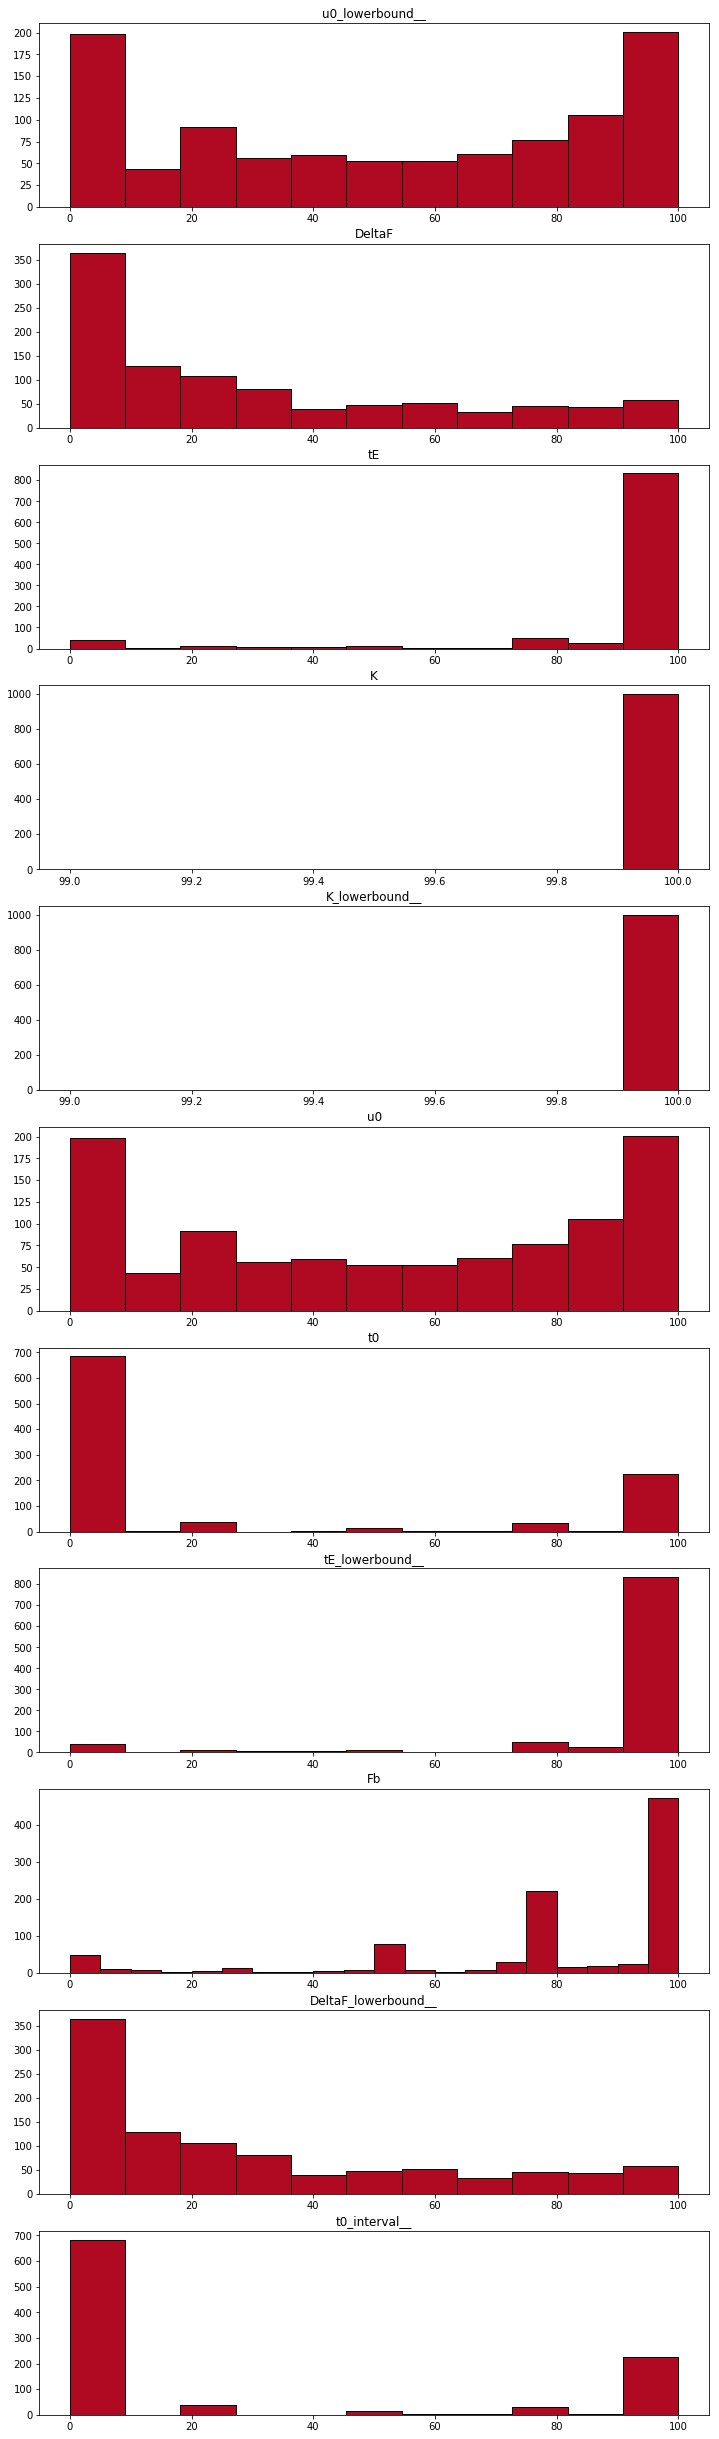

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import sys
sys.path.append("../codebase")

import pymc3 as pm
import theano
import theano.tensor as T
from theano.ifelse import ifelse

from Data import OGLEData

from simulation_based_calibration import SBC

mpl.rc('text', usetex=False)

events = [] # data for each event
 
i = 0
n_events = 100
data_path = '/home/star/fb90/data/OGLE_ews/2017/'
for entry in sorted(os.listdir(data_path)):
    if (i < n_events):
        event = OGLEData(data_path + entry)
        events.append(event)
        i = i + 1

np.random.seed(42)

for event in events: 
    print("Fitting models for event ", event.event_name)

    output_dir_standard = 'output/' + event.event_name + '/PointSourcePointLens'

    def model_for_sbc(y=None):
        with pm.Model() as model_std:
            # Pre process the data
            event.convert_data_to_fluxes()
            df = event.get_standardized_data()

            # Data
            t = df['HJD - 2450000'].values
            F = df['I_flux'].values
            sigF = df['I_flux_err'].values

            # Custom prior distributions 
            BoundedNormal = pm.Bound(pm.Normal, lower=0.0) # DeltaF is positive
            BoundedNormal1 = pm.Bound(pm.Normal, lower=1.) 

            # Microlensing model parameters
            DeltaF = BoundedNormal('DeltaF', mu=np.max(F), sd=1., testval=3.)
            Fb = pm.Normal('Fb', mu=0., sd=0.1, testval=0.)
            # Posterior is multi-modal in t0 and it's critical that the it is 
            # initialized near the true value
            t0_guess_idx = (np.abs(F - np.max(F))).argmin() 
            t0 = pm.Uniform('t0', t[0], t[-1], 
                testval=t[t0_guess_idx])
            u0 = BoundedNormal('u0', mu=0., sd=1., testval=0.5)
            tE = BoundedNormal('tE', mu=0., sd=600., testval=20.)
            
            # Noise model parameters
            K = BoundedNormal1('K', mu=1., sd=2., testval=1.5)

            u = T.sqrt(u0**2 + ((t - t0)/tE)**2)
            A = lambda u: (u**2 + 2)/(u*T.sqrt(u**2 + 4))

            mean_func = DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

            Y_obs = pm.Normal('y', mu=mean_func, sd=K*sigF, 
                observed=F, shape=len(F))

        return model_std

    sbc = SBC(model_for_sbc, 'y',
            num_simulations=1000,
            sample_kwargs={'draws': 25, 'tune': 50})

    sbc.run_simulations()
    fig, ax = sbc.plot_sbc()

    plt.savefig('SBC.png')